1:30:00

In [1]:
import torch
import tiktoken
from dataloader import GPTModel

GPT_CONFIG_124M = {
    "vocab_size" : 50257,       # Vocabulary Size
    "context_length" : 256,    # Context Length
    "emb_dim" : 768,            # Embedding Dimension
    "n_heads" : 12,             # Numbers of attention heads
    "n_layers" : 12,            # Number of Layers
    "drop_rate" : 0.1,          # Dropout Rate
    "qkv_bias" : False          # Query-key-value-bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
from dataloader import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [3]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
with open("C:\\Users\\NashW\\PycharmProjects\\NeuralNetwork\\data\\datasets\\wizard_of_oz_ch1.txt", 'r', encoding='utf-8') as f:
    wizard_text = f.read()

In [5]:
total_characters = len(wizard_text)
total_tokens = len(tokenizer.encode(wizard_text))

print("Total characters: ", total_characters)
print("Total tokens: ", total_tokens)

Total characters:  5982
Total tokens:  1413


In [6]:
from dataloader import create_dataloader_v1

#Train/Test Ratio
train_ratio = 0.80
split_index = int(train_ratio * len(wizard_text))

train_data = wizard_text[:split_index]
valid_data = wizard_text[split_index:]

torch.manual_seed(123)

train_dataloader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

valid_dataloader = create_dataloader_v1(
    valid_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)


In [7]:
# A check to see that our data was loaded correctly
print(f"Train Loader:")
for x,y in train_dataloader:
    print(x.shape, y.shape)


print("\nValidation Loader:")
for x,y in valid_dataloader:
    print(x.shape, y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation Loader:


In [8]:
# Another way of checking our data
train_tokens = 0
for input_batch, target_batch in train_dataloader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in valid_dataloader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 1024
Validation tokens: 0
All tokens: 1024


In [9]:
#Calculating the initial loss before we begin any sort of training
from dataloader import calc_loss_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_dataloader, model, device)
    val_loss = calc_loss_loader(valid_dataloader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.958444595336914
Validation loss: nan


In [10]:
from dataloader import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [11]:
#Now, let's train the LLM using the training function defined above:

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(

    model,
    train_dataloader,
    valid_dataloader,
    optimizer,
    device,
    num_epochs = num_epochs,
    eval_freq = 5, # How often the loss is calculated for the validation set.
    eval_iter = 5,
    start_context = "Dorothy lived in the",
    tokenizer = tokenizer

)




Epoch 1 (Step 000000): Train loss 9.013, Val loss nan
Dorothy lived in the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [12]:
torch.save(model.state_dict(), "model.pth")

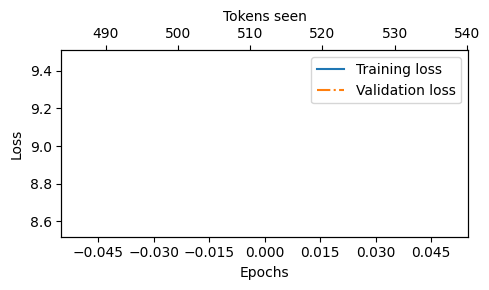

In [13]:
from dataloader import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)